# 肩の高さ・位置を指摘する

In [1]:
# 画像を受け取り
# 正常・傾き・回転・検出失敗のフラグを返す

In [ ]:
# 肩は顔の近くにある

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [84]:
def detect_shoulder(image_path):
    resized_image, gray_image = color_to_gray(image_path) # グレースケール変換
    thresh = to_thresh_binary_inv(gray_image) # 閾値
#     median = cv2.medianBlur(thresh,7) # ごま塩ノイズ
    blur = cv2.GaussianBlur(thresh,(5,5),0)
    canny_image = cv2.Canny(blur, 50, 110) # エッジ変換
    lines = hough_lines_p(resized_image, canny_image) # ハフ変換
    result = judge_shoulder(lines, resized_image) # 結果取得
    return result, canny_image

[ 20 202  92 166  72 -36]
[72.]
[36.]
検出できなかった


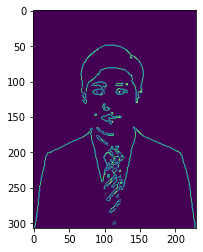

In [85]:
result, canny_image = detect_shoulder('./data/images/image.jpg')
print(result)
plt.imshow(canny_image)

[553 191 600 184  47  -7]
[555 191 600 185  45  -6]
[712 219 744 219  32   0]
[47. 45. 32.]
[7. 6. 0.]
検出できなかった


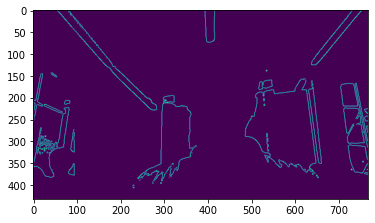

In [61]:
result, canny_image = detect_shoulder('./data/images/20201120_110619.jpg')
print(result)
plt.imshow(canny_image)

[508 170 553 206  45  36]
[367 164 437 151  70 -13]
[45. 70.]
[36. 13.]
('高さ', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))


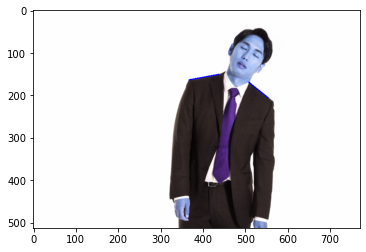

In [54]:
result = detect_shoulder('./data/images/test.jpg')
print(result)

[453 424 542 420  89  -4]
[89.]
[4.]
検出できなかった


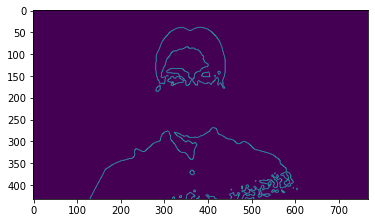

In [78]:
result, canny_image = detect_shoulder('./data/images/diff.jpg')
print(result)
plt.imshow(canny_image)

In [55]:
result = detect_shoulder('./flaskapp/static/images/20201106_101124.jpg')
print(result)

AttributeError: 'NoneType' object has no attribute 'shape'

# 画像サイズを整える

In [7]:
def get_resize_rate(width, height):
    if width > 2000 or height > 2000:
        x_rate = 0.15
        y_rate = 0.15
    elif width > 1000 or height > 1000:
        x_rate = 0.5
        y_rate = 0.5
    else:
        x_rate = 1
        y_rate = 1
    return x_rate, y_rate

# 画像を読み込む
# グレースケールに変換する

In [8]:
def color_to_gray(input_path):
    raw_image = cv2.imread(input_path)
    height, width, channels = raw_image.shape[:3]
    x_rate, y_rate = get_resize_rate(width, height)
    resized_image = cv2.resize(raw_image, dsize=None, fx=x_rate, fy=y_rate)
    gray_image = cv2.cvtColor(resized_image,cv2.COLOR_BGR2GRAY)
    return resized_image, gray_image

In [9]:
resized_image, gray_image = color_to_gray('./data/images/image.jpg')
print(gray_image.shape)

(307, 230)


In [8]:
# 読み込みと同時にグレースケール変換
# gray_image = cv2.imread('./data/images/image.jpg',cv2.IMREAD_GRAYSCALE)

In [9]:
# グレースケール画像を保存する 
# cv2.imwrite('./data/images/output.jpg', gray_image)

# 閾値でパキッと

In [16]:
def to_thresh_binary_inv(gray_image):
    ret,thresh = cv2.threshold(gray_image,115,255,cv2.THRESH_BINARY_INV)
    return thresh
#     plt.imshow(thresh,'gray')

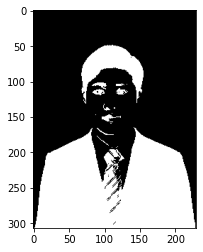

In [22]:
resuzed_image, gray_image = color_to_gray('./data/images/image.jpg')
thresh = to_thresh_binary_inv(gray_image)
plt.imshow(thresh, 'gray')

In [23]:
np.shape(thresh)

(307, 230)

In [12]:
# THRESH_BINARY: パキッと
# _INV: openCV は背景が黒、物体が白なので反転する

# エッジ変換

In [13]:
def to_canny_img(gray_image):
    canny_image = cv2.Canny(gray_image, 50, 110)
    plt.imshow(canny_image)

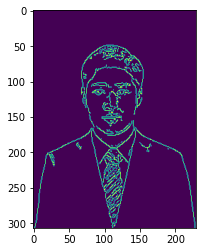

In [14]:
resized_image, gray_image = color_to_gray('./data/images/image.jpg')
to_canny_img(gray_image)

# 輪郭検出

In [15]:
def detect_contours(input_path):
    resized_image, gray_image = color_to_gray(input_path)
    ret,thresh = cv2.threshold(gray_image,115,255,cv2.THRESH_BINARY_INV)
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     # 小さい輪郭は除く
    contours = list(filter(lambda x: cv2.contourArea(x) >3000, contours))
    cv2.drawContours(resized_image, contours, -1, (0, 255, 0), 2)
    plt.imshow(resized_image)

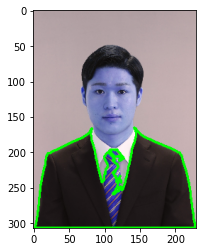

In [16]:
detect_contours('./data/images/image.jpg')

In [17]:
# image = cv2.drawContours(mono_image, contours, -1, (0,255,0), 3)

## 輪郭近似

In [18]:
# 輪郭描画
# for i in range(len(contours)):
#     if hierarchy[0][i][3] == -1:
#         cv2.drawContours(resized_image, contours, i, (0, 255, 0), 2)
# plt.imshow(resized_image)

In [19]:
# cnt = contours[0]
# epsilon = 0.5*cv2.arcLength(cnt,True)
# approx = cv2.approxPolyDP(cnt,epsilon,True)

In [20]:
# cv2.drawContours(resized_image, [approx], -1, (0, 255, 0), 2)
# plt.imshow(resized_image)

# テスト

In [21]:
def hough_lines_p_2(canny_image):
    lines = cv2.HoughLinesP(canny_image, rho=1, theta=np.pi/360, threshold=50, minLineLength=40, maxLineGap=10)
    print("hough_lines: ", len(lines))
    for line in lines:
        x1, y1, x2, y2 = line[0]
#         cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
#         plt.imshow(resized_image)
        xa = (x2-x1)
        ya = (y2-y1)
        # 傾き2以上を除く
        if(not(ya > 50 or ya < -50) and xa > 25):
            cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
            plt.imshow(resized_image)
    
    return lines

hough_lines:  35
[63. 58.]
[13. 47.]


'高さ'

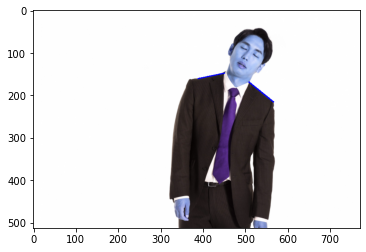

In [36]:
resized_image, gray_image = color_to_gray('./data/images/test.jpg')
canny_image = cv2.Canny(gray_image, 50, 110)
lines = hough_lines_p_2(canny_image)
judge_shoulder(lines)

In [ ]:
resized_image, gray_image = color_to_gray('./data/images/test2.jpg')
canny_image = cv2.Canny(gray_image, 50, 110)
lines = hough_lines_p_2(canny_image)
judge_shoulder(lines)

In [37]:
lines = hough_lines_p('./data/images/test3.jpg')
to_canny_img('./data/images/test3.jpg')
judge_shoulder(lines)

TypeError: hough_lines_p() missing 1 required positional argument: 'canny_image'

# 直線検出

## 確率的ハフ変換で直線を抽出

In [56]:
def hough_lines_p(resized_image, canny_image):
    height, width, channels = resized_image.shape[:3]
    lines = cv2.HoughLinesP(canny_image, rho=1, theta=np.pi/360, threshold=50, minLineLength=25, maxLineGap=10)
#     print("hough_lines: ", len(lines))
#     print("hough_lines: ", lines)
    for line in lines:
        x1, y1, x2, y2 = line[0]
#         cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
#         plt.imshow(resized_image)
        xa = (x2-x1)
        ya = (y2-y1)
        # 画面サイズ半分以上の直線を除く
        if xa < width/2:
            # 上部100pxまでの直線を除く
            if y1>100 or y2>100:
                # x方向に短すぎる直線を除く
                if xa > 25: 
                    # 傾き2以上を除いた描画
                    if ya>-50 and ya<50:
                        cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
                        plt.imshow(resized_image)
    
    return lines

In [44]:
def judge_shoulder(lines, resized_image):
    # 画面サイズを取得する
    height, width, channels = resized_image.shape[:3]
    xline = []
    yline = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        xa = (x2-x1)
        ya = (y2-y1)
        # 画面サイズ半分以上の直線を除く
        if xa < width/2:
            # 上部100pxまでの直線を除く
            if y1>100 or y2>100:
                # x方向に短すぎる直線を除く
                if xa > 25:
                    # 傾き2以上を除く
                    if ya>-50 and ya<50:
                        line = np.append(line, [xa,ya])
                        # 負の数を正の数に変換
                        if(xa < 0):
                            xa = -xa
                        if(ya < 0):
                            ya = -ya
                        xline =np.append(xline, xa)
                        yline =np.append(yline, ya)
                        print(line)
    print(xline)
    print(yline)
    # ここかえたい
    if (len(xline) != 2 or len(yline) != 2):
        return("検出できなかった")
    else:
        if((yline[0]-yline[1] > 10) or (yline[0]-yline[1] < -10)):
            return("高さ")
        elif((xline[0]-xline[1] > 10) or (xline[0]-xline[1] < -10)):
            return("回転")
        else:
            return("おけ")

## ハフ変換で直線を抽出する関数

In [34]:
def hough_lines(input_path):
    raw_image = cv2.imread(input_path)
    resized_image = cv2.resize(raw_image, dsize=None, fx=0.15, fy=0.15)
    gray_image = cv2.cvtColor(resized_image,cv2.COLOR_BGR2GRAY)
    canny_image = cv2.Canny(gray_image, 50, 110)

    lines = cv2.HoughLines(canny_image, rho=1, theta=np.pi/180, threshold=60)
    print("hough_lines: ", len(lines))

    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
        plt.imshow(resized_image)

hough_lines:  44


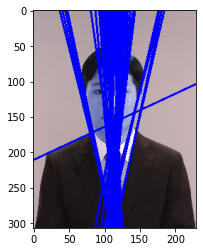

In [35]:
hough_lines('./data/images/image.jpg')